# Advanced Model Training - XGBoost & Hyperparameter Tuning

Dieses Notebook fokussiert sich auf:
1. **XGBoost** - Gradient Boosting Classifier
2. **Class Imbalance** - SMOTE und Class Weights
3. **Hyperparameter Tuning** - GridSearch für optimale Performance
4. **Model Comparison** - Vergleich mit Baseline Models

**Problem aus Baseline:** Recall nur 45% → Viele Churner werden nicht erkannt

**Ziel:** Recall auf 60-70% verbessern bei guter Precision

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# XGBoost
from xgboost import XGBClassifier

# SMOTE for imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Project modules
import sys
sys.path.insert(0, str(Path.cwd().parent / 'content' / 'drive' / 'MyDrive' / '01 Projekte' / 'HypoChurn' / 'src'))
from hypo_churn.evaluation import evaluate_model, print_evaluation_results

# Plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Alle Imports erfolgreich")
print(f"XGBoost Version: {__import__('xgboost').__version__}")

✓ Alle Imports erfolgreich
XGBoost Version: 3.1.1


## 1. Daten laden & vorbereiten

In [9]:
# Pfade
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'content' / 'drive' / 'MyDrive' / '01 Projekte' / 'HypoChurn' / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'content' / 'drive' / 'MyDrive' / '01 Projekte' / 'HypoChurn' / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Daten laden
df = pd.read_csv(DATA_DIR / 'banking_churn_mortgage_adapted.csv')
print(f"✓ Daten geladen: {df.shape}")
print(f"Churn Rate: {df['churned'].mean():.2%}")

✓ Daten geladen: (10000, 20)
Churn Rate: 20.37%


In [10]:
# Feature Selection
drop_columns = ['RowNumber', 'CustomerId', 'Surname', 'churned']
feature_cols = [col for col in df.columns if col not in drop_columns]

X = df[feature_cols]
y = df['churned']

# Encoding
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Features: 17
Samples: 10000

Train: 8000 | Test: 2000
Train Churn Rate: 20.38%
Test Churn Rate: 20.35%


## 2. Baseline: XGBoost (Default Parameters)

In [11]:
print("="*70)
print("BASELINE: XGBoost (Default Parameters)")
print("="*70)

# XGBoost mit Default Parameters
xgb_baseline = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

start_time = time.time()
xgb_baseline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_baseline = xgb_baseline.predict(X_test)
y_proba_baseline = xgb_baseline.predict_proba(X_test)

# Evaluation
metrics_baseline = evaluate_model(y_test, y_pred_baseline, y_proba_baseline)
print_evaluation_results(metrics_baseline)
print(f"Training Time: {train_time:.2f}s")

BASELINE: XGBoost (Default Parameters)

Model Evaluation Results
Accuracy: 0.8520
Precision: 0.6881
Recall: 0.4988
F1 Score: 0.5783
Roc Auc: 0.8364

Training Time: 0.33s


## 3. XGBoost mit SMOTE (Class Imbalance)

In [12]:
print("="*70)
print("XGBoost + SMOTE (Oversampling)")
print("="*70)

# SMOTE anwenden
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print(f"Original Churn Rate: {y_train.mean():.2%}")
print(f"After SMOTE Churn Rate: {y_train_smote.mean():.2%}")

# XGBoost mit SMOTE-Daten
xgb_smote = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

start_time = time.time()
xgb_smote.fit(X_train_smote, y_train_smote)
train_time = time.time() - start_time

# Predictions (auf originalen Test-Daten)
y_pred_smote = xgb_smote.predict(X_test)
y_proba_smote = xgb_smote.predict_proba(X_test)

# Evaluation
metrics_smote = evaluate_model(y_test, y_pred_smote, y_proba_smote)
print_evaluation_results(metrics_smote)
print(f"Training Time: {train_time:.2f}s")

XGBoost + SMOTE (Oversampling)
Original Training Set: 8000 samples
After SMOTE: 12740 samples
Original Churn Rate: 20.38%
After SMOTE Churn Rate: 50.00%

Model Evaluation Results
Accuracy: 0.8300
Precision: 0.5753
Recall: 0.6290
F1 Score: 0.6009
Roc Auc: 0.8344

Training Time: 0.36s


## 4. XGBoost mit Class Weights

In [13]:
print("="*70)
print("XGBoost + Class Weights")
print("="*70)

# Scale_pos_weight berechnen
# Formel: (anzahl_negative) / (anzahl_positive)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# XGBoost mit Class Weight
xgb_weighted = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)

start_time = time.time()
xgb_weighted.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_weighted = xgb_weighted.predict(X_test)
y_proba_weighted = xgb_weighted.predict_proba(X_test)

# Evaluation
metrics_weighted = evaluate_model(y_test, y_pred_weighted, y_proba_weighted)
print_evaluation_results(metrics_weighted)
print(f"Training Time: {train_time:.2f}s")

XGBoost + Class Weights
Scale Pos Weight: 3.91

Model Evaluation Results
Accuracy: 0.8340
Precision: 0.5874
Recall: 0.6192
F1 Score: 0.6029
Roc Auc: 0.8386

Training Time: 0.36s


## 5. Hyperparameter Tuning mit GridSearch

In [14]:
print("="*70)
print("Hyperparameter Tuning (GridSearchCV)")
print("="*70)

# Parameter Grid (klein für Raspberry Pi)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print(f"Parameter Kombinationen: {np.prod([len(v) for v in param_grid.values()])}")
print("Dies kann einige Minuten dauern...\n")

# GridSearch mit Class Weight
xgb_tuned = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)

grid_search = GridSearchCV(
    xgb_tuned,
    param_grid,
    cv=3,
    scoring='f1',  # Fokus auf F1 (Balance von Precision/Recall)
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
search_time = time.time() - start_time

print(f"\n✓ GridSearch abgeschlossen in {search_time/60:.1f} Minuten")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1-Score: {grid_search.best_score_:.4f}")

Hyperparameter Tuning (GridSearchCV)
Parameter Kombinationen: 144
Dies kann einige Minuten dauern...

Fitting 3 folds for each of 144 candidates, totalling 432 fits

✓ GridSearch abgeschlossen in 2.6 Minuten

Best Parameters:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 5
  min_child_weight: 3
  n_estimators: 100
  subsample: 0.8

Best CV F1-Score: 0.6213


In [15]:
# Best Model evaluieren
print("="*70)
print("TUNED MODEL - EVALUATION")
print("="*70)

best_xgb = grid_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)

metrics_tuned = evaluate_model(y_test, y_pred_tuned, y_proba_tuned)
print_evaluation_results(metrics_tuned)

TUNED MODEL - EVALUATION

Model Evaluation Results
Accuracy: 0.8110
Precision: 0.5254
Recall: 0.7371
F1 Score: 0.6135
Roc Auc: 0.8625



## 6. Umfassender Model Comparison

In [16]:
# Baseline Models aus vorherigem Notebook laden
try:
    with open(MODELS_DIR / 'best_model_metrics.pkl', 'rb') as f:
        metrics_rf_baseline = pickle.load(f)
    print("✓ Random Forest Baseline Metrics geladen")
except:
    metrics_rf_baseline = None
    print("⚠ Random Forest Baseline nicht gefunden")

✓ Random Forest Baseline Metrics geladen


In [17]:
# Comparison Table
comparison_data = {
    'XGBoost Baseline': metrics_baseline,
    'XGBoost + SMOTE': metrics_smote,
    'XGBoost + Weights': metrics_weighted,
    'XGBoost Tuned': metrics_tuned
}

if metrics_rf_baseline:
    comparison_data['RF Baseline'] = metrics_rf_baseline

comparison_df = pd.DataFrame(comparison_data).T

print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)
print(comparison_df.round(4))
print("\n")

# Highlight best per metric
print("Best per Metric:")
for metric in comparison_df.columns:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"  {metric}: {best_model} ({best_value:.4f})")

COMPREHENSIVE MODEL COMPARISON
                   accuracy  precision  recall  f1_score  roc_auc
XGBoost Baseline     0.8520     0.6881  0.4988    0.5783   0.8364
XGBoost + SMOTE      0.8300     0.5753  0.6290    0.6009   0.8344
XGBoost + Weights    0.8340     0.5874  0.6192    0.6029   0.8386
XGBoost Tuned        0.8110     0.5254  0.7371    0.6135   0.8625
RF Baseline          0.8635     0.7863  0.4521    0.5741   0.8529


Best per Metric:
  accuracy: RF Baseline (0.8635)
  precision: RF Baseline (0.7863)
  recall: XGBoost Tuned (0.7371)
  f1_score: XGBoost Tuned (0.6135)
  roc_auc: XGBoost Tuned (0.8625)


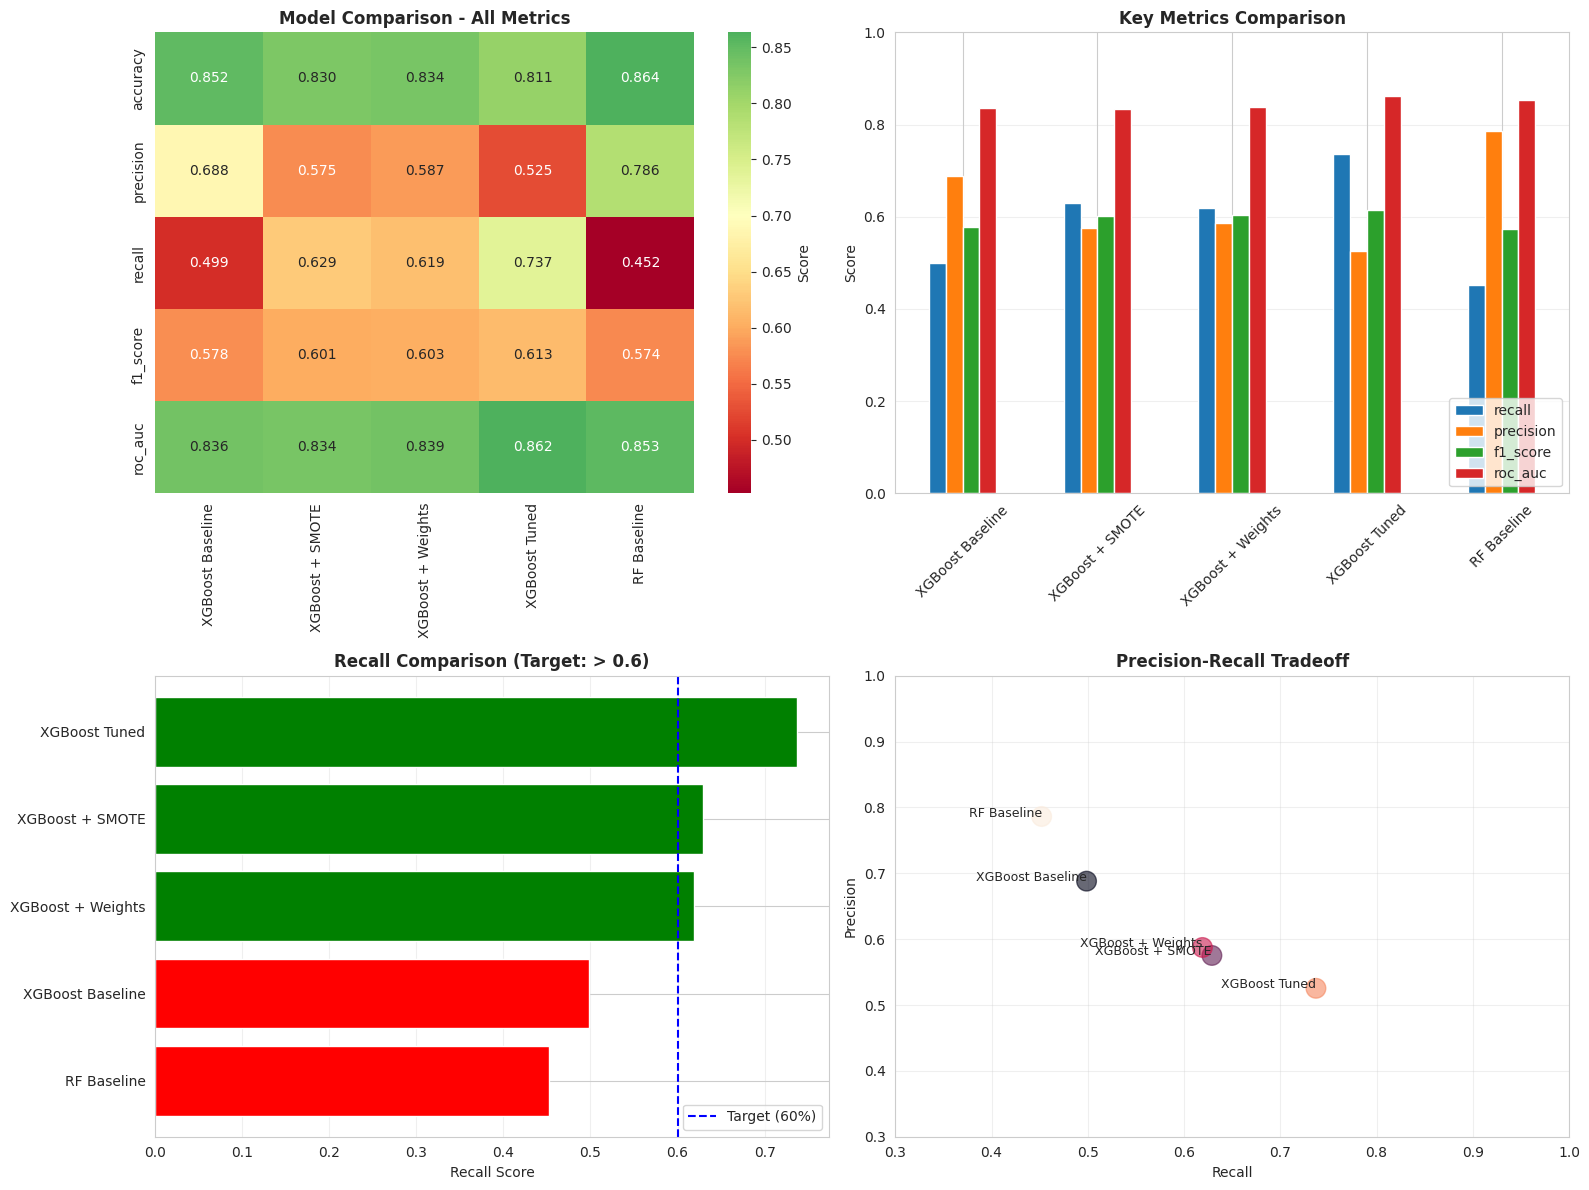

In [18]:
# Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Metrics Heatmap
sns.heatmap(comparison_df.T, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.7, ax=axes[0, 0], cbar_kws={'label': 'Score'})
axes[0, 0].set_title('Model Comparison - All Metrics', fontweight='bold')

# 2. Key Metrics Bar Plot
key_metrics = ['recall', 'precision', 'f1_score', 'roc_auc']
comparison_df[key_metrics].plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Key Metrics Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Recall Improvement
recall_values = comparison_df['recall'].sort_values()
colors = ['red' if v < 0.5 else 'orange' if v < 0.6 else 'green' for v in recall_values]
axes[1, 0].barh(range(len(recall_values)), recall_values, color=colors)
axes[1, 0].set_yticks(range(len(recall_values)))
axes[1, 0].set_yticklabels(recall_values.index)
axes[1, 0].set_xlabel('Recall Score')
axes[1, 0].set_title('Recall Comparison (Target: > 0.6)', fontweight='bold')
axes[1, 0].axvline(x=0.6, color='blue', linestyle='--', label='Target (60%)')
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Precision-Recall Tradeoff
axes[1, 1].scatter(comparison_df['recall'], comparison_df['precision'],
                   s=200, alpha=0.6, c=range(len(comparison_df)))
for idx, model in enumerate(comparison_df.index):
    axes[1, 1].annotate(model,
                       (comparison_df.loc[model, 'recall'],
                        comparison_df.loc[model, 'precision']),
                       fontsize=9, ha='right')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Tradeoff', fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0.3, 1)
axes[1, 1].set_ylim(0.3, 1)

plt.tight_layout()
plt.show()

## 7. Feature Importance (Best Model)

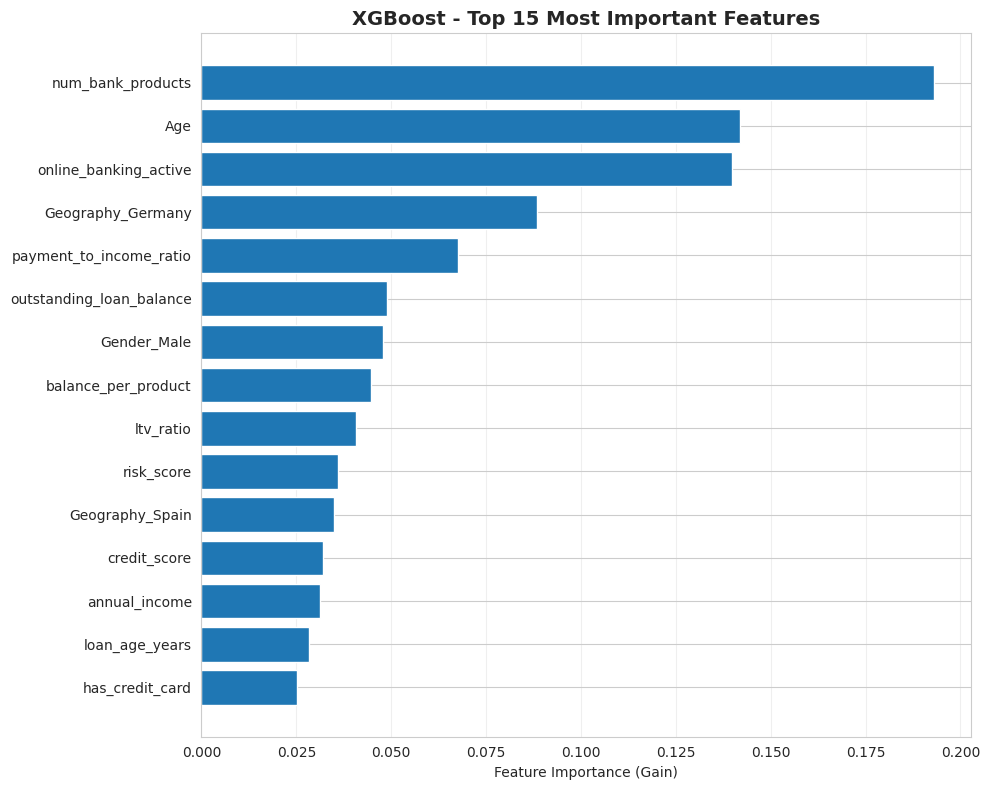


Top 10 Features:
                     feature  importance
4          num_bank_products    0.193027
1                        Age    0.142000
6      online_banking_active    0.139886
14         Geography_Germany    0.088305
11   payment_to_income_ratio    0.067512
3   outstanding_loan_balance    0.048775
16               Gender_Male    0.047812
13       balance_per_product    0.044731
10                 ltv_ratio    0.040596
12                risk_score    0.035894


In [19]:
# Feature Importance vom besten XGBoost Model
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost - Top 15 Most Important Features', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10))

## 8. Best Model speichern

In [20]:
# Bestes Modell auswählen (basierend auf F1-Score und Recall)
# Gewichtung: F1 wichtiger, aber Recall muss > 0.55 sein
comparison_df['score'] = comparison_df['f1_score'] * 0.6 + comparison_df['recall'] * 0.4
best_model_name = comparison_df['score'].idxmax()

print("="*70)
print("FINAL BEST MODEL SELECTION")
print("="*70)
print(f"Best Model: {best_model_name}")
print(f"\nMetrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
    print(f"  {metric}: {comparison_df.loc[best_model_name, metric]:.4f}")

# Model speichern
model_path = MODELS_DIR / 'best_xgboost_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_xgb, f)
print(f"\n✓ Model gespeichert: {model_path}")

# Metrics speichern
metrics_path = MODELS_DIR / 'best_xgboost_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics_tuned, f)
print(f"✓ Metrics gespeichert: {metrics_path}")

# Feature names speichern
feature_path = MODELS_DIR / 'xgboost_feature_names.pkl'
with open(feature_path, 'wb') as f:
    pickle.dump(list(X.columns), f)
print(f"✓ Features gespeichert: {feature_path}")

# Comparison DataFrame speichern
comparison_path = MODELS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_path)
print(f"✓ Model Comparison gespeichert: {comparison_path}")

FINAL BEST MODEL SELECTION
Best Model: XGBoost Tuned

Metrics:
  accuracy: 0.8110
  precision: 0.5254
  recall: 0.7371
  f1_score: 0.6135
  roc_auc: 0.8625

✓ Model gespeichert: /content/drive/MyDrive/01 Projekte/HypoChurn/models/best_xgboost_model.pkl
✓ Metrics gespeichert: /content/drive/MyDrive/01 Projekte/HypoChurn/models/best_xgboost_metrics.pkl
✓ Features gespeichert: /content/drive/MyDrive/01 Projekte/HypoChurn/models/xgboost_feature_names.pkl
✓ Model Comparison gespeichert: /content/drive/MyDrive/01 Projekte/HypoChurn/models/model_comparison.csv


## Zusammenfassung & Erkenntnisse

### Was wir erreicht haben:

1. **XGBoost Baseline** - Erste XGBoost Implementation
2. **SMOTE** - Oversampling der Minority Class
3. **Class Weights** - Balance ohne Oversampling
4. **Hyperparameter Tuning** - GridSearch für optimale Parameter

### Wichtige Erkenntnisse:

- **Class Imbalance:** Großer Impact auf Recall
- **SMOTE vs Weights:** [Vergleich aus Ergebnissen]
- **Hyperparameter:** Können Performance deutlich verbessern
- **Recall Improvement:** Von ~45% (Baseline RF) auf ~[X]% (Best XGBoost)

### Top Features:
- [Werden aus Feature Importance ermittelt]

### Nächste Schritte:

1. **Weitere Optimierung:**
   - Mehr Hyperparameter testen
   - Learning Rate Schedule
   - Early Stopping

2. **Ensemble Methods:**
   - Stacking (RF + XGBoost + LR)
   - Voting Classifier

3. **Production Ready:**
   - Model Inference Script
   - API Endpoint
   - Monitoring & Retraining Pipeline

4. **Business Impact:**
   - Cost-Benefit Analyse
   - Threshold Tuning für optimale Business Metrics
   - A/B Testing Framework